# Lab 7

##  Author: Quentin Smith
## Date: 3/7/20

## 1. Overview

### a.) Objective

Objective is to improve model performance with ensemble learning. The model performance relies on the accuracy to classify the target variable, culvitar (Class1, Class2, Class3), based on the 13 variables: Alcohol, Malic Acid, Ash, Alcalinity of Ash, Magnesium, Total Phenols, Flavanoids, Nonflavanoid Phenols, Proanthocyanins, Color Intensity, Hue, OD280/OD315 of diluted wines, Proline. 

We will be using various ensemble learning techniques to improve upon the base performance of classification. 

Our base classification techniques will be: Random Forest, k Nearest Neighbor (kNN), Support Vector Classification (SVC), and Logisitc Regression.

Our ensemble techniques will include bagging (Random Forest,  kNN,  SVC, Logistic Regression), boosting (Ada Boost, Gradient Boost, XG Boost, Ensemble), stacked model of a (Random Forest,  kNN,  SVC, Logistic Regression input into a Logistic Regression meta-classifier) usng class labels, and stacked model  w/ Grid Search Cross Validation hyperparameters.

### b.) Background Information

**Ensemble learning** is a strategy in which a group of models are used to solve a challenging problem, by strategically combining diverse machine learning models into one single predictive mode [1]. 

Ensemble methods improve upon the overall performace by lowering bias (boosting), reducing variance (bagging), or increase prediction accuracy (stacking).

**Bagging** includes [2]:
    1. Create many (e.g. 100) random sub-samples of our dataset with replacement.
    2. Train a CART model on each sample.
    3. Given a new dataset, calculate the average prediction from each model.
    
The idea of **boosting** is to train weak learners sequentially, each trying to correct its predecessor [3].

**Stacking** is meant to explore a space of different models for the same problem. The idea is that you can attack a learning problem with different types of models which are capable to learn some part of the problem, but not the whole space of the problem [4]. Thus you can stack intermediate predictions on top of each other with whichever performs best for that certain subset of data. 

References: 
1. https://medium.com/@saugata.paul1010/ensemble-learning-bagging-boosting-stacking-and-cascading-classifiers-in-machine-learning-9c66cb271674
2. https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/
3. https://medium.com/greyatom/a-quick-guide-to-boosting-in-ml-acf7c1585cb5
4. https://www.geeksforgeeks.org/stacking-in-machine-learning/

## 2. Data

The data is the results of a chemical analysis of wines grown in the same region in Italy by three different cultivators. There are thirteen different measurements taken for different constituents found in the three types of wine. The data we will be working with can be downloaded from https://scikit-learn.org/stable/datasets/index.html#wine-recognition-dataset. A copy of UCI ML Wine recognition datasets. https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data (Direct Link to data set). 

In [ ]:
#General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Seperate into train and testing sets
from sklearn.model_selection import train_test_split

#For logistic Regression
from sklearn.linear_model import LogisticRegression 

#Confusion Matrix
from sklearn.metrics import confusion_matrix , accuracy_score, recall_score, precision_score, f1_score

#Ignore warnings for furute warnings scikit
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#Correlation
import seaborn as sns

#Feature importance step-wise
import statsmodels.api as sm

#Random Forest
from sklearn.ensemble.forest import RandomForestClassifier

#kNN
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [ ]:
df = pd.read_csv("/Users/hv2486co/Desktop/inProgress/inet4061/wine_data1.csv", 
                 names=["Class", "Alcohol", "Malic Acid", "Ash","Alcalinity of Ash", "Magnesium", "Total Phenols", 
                        "Flavanoids", "Nonflavanoid Phenols", "Proanthocyanins", "Color Intensity", "Hue", 
                        "OD280/OD315 of diluted wines", "Proline"])
x = df.drop(['Class'], axis = 1)
y = df.Class

We have cleaned up the data a bit. There are no nulls and we added column headers to have more description to the data. We will explore a bit more about the data with the summary statistics.

## 3. Exploratory Data Analysis

In [ ]:
df.shape

(178, 14)

class1:  59
class2:  71
class3:  48


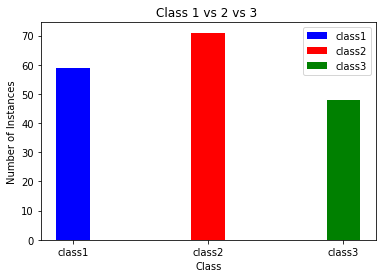

In [ ]:
class1 = sum(df['Class'] == 1)
class2 = sum(df['Class'] == 2)
class3 = sum(df['Class'] == 3)

plt.bar('class1', class1, color = 'b', width = 0.25, label='class1')
plt.bar('class2', class2, color = 'r', width = 0.25, label='class2')
plt.bar('class3', class3, color = 'g', width = 0.25, label='class3')

#X = np.arange(1)
print("class1: ",class1)
print("class2: ",class2)
print("class3: ",class3)

plt.title("Class 1 vs 2 vs 3 ")
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.legend(loc='upper right')

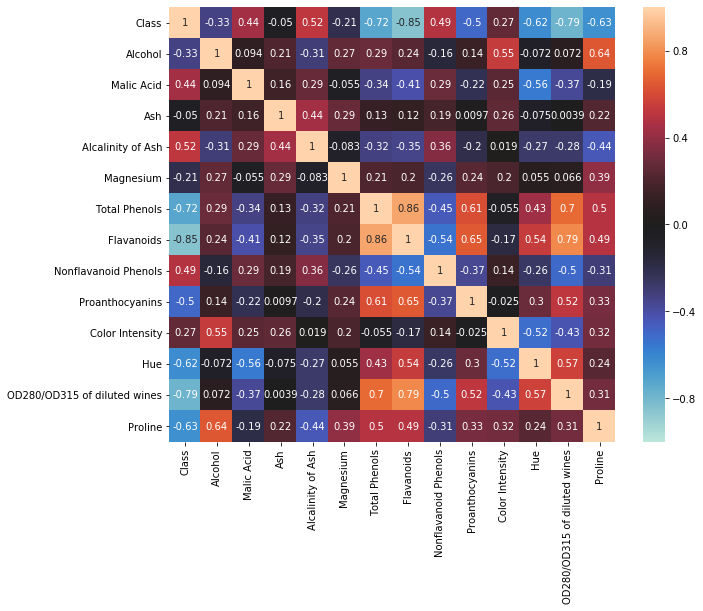

In [ ]:
df = pd.DataFrame(df, columns=["Class", "Alcohol", "Malic Acid", "Ash","Alcalinity of Ash", "Magnesium", "Total Phenols", 
                        "Flavanoids", "Nonflavanoid Phenols", "Proanthocyanins", "Color Intensity", "Hue", 
                        "OD280/OD315 of diluted wines", "Proline"])
fig, ax = plt.subplots(figsize=(10,8))
corrmat = df.corr() # Omit year
sns.heatmap(corrmat,-1,1,ax=ax,center=0,annot=True);

In [ ]:
def stepwise_selection(x, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):

    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(x.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(x[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
#            best_feature = new_pval.argmin()
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(x[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(x, y)

print('resulting features:')
print(result)

Add  Flavanoids                     with p-value 2.73665e-50
Add  Proline                        with p-value 6.52009e-11
Add  Color Intensity                with p-value 1.16552e-16
Add  Alcalinity of Ash              with p-value 5.72185e-06
Add  OD280/OD315 of diluted wines   with p-value 5.39083e-06
Add  Alcohol                        with p-value 0.00283291
resulting features:
['Flavanoids', 'Proline', 'Color Intensity', 'Alcalinity of Ash', 'OD280/OD315 of diluted wines', 'Alcohol']


In [ ]:
df.head(3)

,Class,Alcohol,Malic Acid,Ash,Alcalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid Phenols,Proanthocyanins,Color Intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


In [ ]:
df.describe()

,Class,Alcohol,Malic Acid,Ash,Alcalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid Phenols,Proanthocyanins,Color Intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [ ]:
x_13 = df.drop(['Class'], axis = 1)
y_13 = df.Class
x_6 = df[['Flavanoids', 'Proline', 'Color Intensity', 'Alcalinity of Ash', 'OD280/OD315 of diluted wines', 'Alcohol']]
y_6 = df.Class

In [ ]:
classifier = LogisticRegression(random_state = 0) 
classifier.fit(x_13, y_13)

y_pred = classifier.predict(x_13)


cm = confusion_matrix(y_13,y_pred) 
  
print ("Confusion Matrix : \n", cm) 

print ("Accuracy : ", accuracy_score(y_13,y_pred))
print("Recall : ", recall_score(y_13,y_pred,pos_label='positive',
                                           average ='micro'))
print("Precision : ", precision_score(y_13,y_pred,pos_label='positive',
                                           average ='micro'))

Confusion Matrix : 
 [[56  3  0]
 [ 0 69  2]
 [ 0  1 47]]
Accuracy :  0.9662921348314607
Recall :  0.9662921348314607
Precision :  0.9662921348314607


C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [ ]:
classifier = LogisticRegression(random_state = 0) 
classifier.fit(x_6, y_6)

y_pred = classifier.predict(x_6)


cm = confusion_matrix(y_6,y_pred) 
  
print ("Confusion Matrix : \n", cm) 


print ("Accuracy : ", accuracy_score(y_6,y_pred))
print("Recall : ", recall_score(y_6,y_pred,pos_label='positive',
                                           average ='micro'))
print("Precision : ", precision_score(y_6,y_pred,pos_label='positive',
                                           average ='micro'))

Confusion Matrix : 
 [[55  4  0]
 [ 2 67  2]
 [ 0  2 46]]
Accuracy :  0.9438202247191011
Recall :  0.9438202247191011
Precision :  0.9438202247191011


C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [ ]:
# Split data into target value (Class) and independent value
y = df.Class
x = df[['Flavanoids', 'Proline', 'Color Intensity', 'Alcalinity of Ash', 'OD280/OD315 of diluted wines', 'Alcohol']]

The exploratory data analysis has shown us a few insights. The target variable is the Class (3 types of wine). The three classes are relatively balanced with class_1 (59), class_2 (71), class_3 (48). There are 13 indpendent variables listed above. When running stepwise selection we see that 6 variables are needed to describe the dataset. I ran a basic logistic regression to compare the accuracy on the whole data frame. 

We do not need to split this data into training and testing set because the validation methods we will be using uses cross validation. 

## 4. Models/ Techniques

### a.) Baseline and Bagging Case

In [ ]:
from sklearn.model_selection import cross_val_score
RANDOM_SEED = 0
#Base Learners
rf_clf = RandomForestClassifier(n_estimators=10, random_state=RANDOM_SEED)

knn_clf = KNeighborsClassifier(n_neighbors=2)
svc_clf = SVC(C=10000.0, kernel='rbf', random_state=RANDOM_SEED)

lr_clf = LogisticRegression(C=20000, penalty='l2', random_state=RANDOM_SEED)


classifier_array = [rf_clf, knn_clf, svc_clf, lr_clf]
labels = [clf.__class__.__name__ for clf in classifier_array]
normal_accuracy = []
normal_std = []
bagging_accuracy = []
bagging_std = []
for clf in classifier_array:
    cv_scores = cross_val_score(clf, x, y, cv=3, n_jobs=-1)
    bagging_clf = BaggingClassifier(clf, max_samples=0.4, max_features=3, random_state=RANDOM_SEED)
    bagging_scores = cross_val_score(bagging_clf, x, y, cv=3, n_jobs=-1)
    
    normal_accuracy.append(np.round(cv_scores.mean(),4))
    normal_std.append(np.round(cv_scores.std(),4))
    
    bagging_accuracy.append(np.round(bagging_scores.mean(),4))
    bagging_std.append(np.round(bagging_scores.std(),4))
    
    print("Accuracy: %0.4f (+/- %0.4f) [Normal %s]" % (cv_scores.mean(), cv_scores.std(), clf.__class__.__name__))
    print("Accuracy: %0.4f (+/- %0.4f) [Bagging %s]\n" % (bagging_scores.mean(), bagging_scores.std(), clf.__class__.__name__))

Accuracy: 0.9442 (+/- 0.0478) [Normal RandomForestClassifier]
Accuracy: 0.9385 (+/- 0.0478) [Bagging RandomForestClassifier]

Accuracy: 0.7024 (+/- 0.0193) [Normal KNeighborsClassifier]
Accuracy: 0.8489 (+/- 0.0752) [Bagging KNeighborsClassifier]

Accuracy: 0.9049 (+/- 0.0613) [Normal SVC]
Accuracy: 0.8829 (+/- 0.1112) [Bagging SVC]

Accuracy: 0.8662 (+/- 0.1295) [Normal LogisticRegression]
Accuracy: 0.9273 (+/- 0.0476) [Bagging LogisticRegression]



### b.) Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from xgboost import XGBClassifier
ada_boost = AdaBoostClassifier(n_estimators=5)
grad_boost = GradientBoostingClassifier(n_estimators=10)
xgb_boost = XGBClassifier(max_depth=5, learning_rate=0.001)
ensemble_clf = EnsembleVoteClassifier(clfs=[ada_boost, grad_boost, xgb_boost], voting='hard')
boosting_labels = ['Ada Boost', 'Gradient Boost', 'XG Boost', 'Ensemble']
for clf, label in zip([ada_boost, grad_boost, xgb_boost, ensemble_clf], boosting_labels):
    scores = cross_val_score(clf, x_train, y_train, cv=3, scoring='accuracy')
    print("Accuracy: {0:.3f}, Variance: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Accuracy: 0.881, Variance: (+/-) 0.048 [Ada Boost]
Accuracy: 0.929, Variance: (+/-) 0.027 [Gradient Boost]
Accuracy: 0.929, Variance: (+/-) 0.020 [XG Boost]
Accuracy: 0.936, Variance: (+/-) 0.030 [Ensemble]


### c.) Stacked Model of Multiple Models

In [ ]:
RANDOM_SEED = 0
from sklearn.model_selection import train_test_split

#Base Learners
rf_clf = RandomForestClassifier(n_estimators=10, random_state=RANDOM_SEED)
knn_clf = KNeighborsClassifier(n_neighbors=2)
svc_clf = SVC(C=10000.0, kernel='rbf', random_state=RANDOM_SEED)
lr_clf = LogisticRegression(C=20000, penalty='l2', random_state=RANDOM_SEED)

lr = LogisticRegression(random_state=RANDOM_SEED) # meta classifier
sclf = StackingClassifier(classifiers=[rf_clf, knn_clf, svc_clf, lr_clf], meta_classifier=lr)
classifier_array = [rf_clf, knn_clf, svc_clf, lr_clf, sclf]
labels = [clf.__class__.__name__ for clf in classifier_array]
acc_list = []
var_list = []
for clf, label in zip(classifier_array, labels):
    cv_scores = cross_val_score(clf, x, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (cv_scores.mean(), cv_scores.std(), label))
    acc_list.append(np.round(cv_scores.mean(),4))
    var_list.append(np.round(cv_scores.std(),4))
    #print("Accuracy: {} (+/- {}) [{}]".format(np.round(scores.mean(),4), np.round(scores.std(),4), label))

Accuracy: 0.9442 (+/- 0.0478) [RandomForestClassifier]
Accuracy: 0.7024 (+/- 0.0193) [KNeighborsClassifier]
Accuracy: 0.9049 (+/- 0.0613) [SVC]
Accuracy: 0.8662 (+/- 0.1295) [LogisticRegression]


C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_ms

Accuracy: 0.8885 (+/- 0.1106) [StackingClassifier]


### d.) Grid Search Cross Validation hyperparameters:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor


learn_rates = [0.02, 0.05]
max_depths = [1, 2]
min_samples_leaf = [5,10]
min_samples_split = [5,10]

param_grid = {'learning_rate': learn_rates,
              'max_depth': max_depths,
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split}

grid_search = GridSearchCV(GradientBoostingRegressor(loss='huber'),
                           param_grid, cv=3, return_train_score=True)

grid_search.fit(x_train, y_train)
print('Accuracy: %.2f' %grid_search.score(x_train, y_train))

Accuracy: 0.96


## 5. Conclusion

### a.) Summary

The six variables we chose to describe our target variables was most accurate when using stacking with grid search validation hyperparameters at 0.96. The least accurate test is our base performance of kNN at 0.7024.  

The baseline to our data model accuracy performance is as follows: random forest 0.9442, kNN 0.7024, SVC 0.9049,  and Logorithmic Regression 0.8662. 

We can see from the table above under a.) Baseline and Bagging Case that the bagging case did not always beform better. Bagging as discussed in the background reduces variance. Since the accuracy was a bit off in the base case, reducing the variance will reduce accuracy as we see in all tests except kNN and Logistic Regression. 

Next we tried boosting. The accuracy performance is as follows: random forest 0.881, Gradient Boosting 0.929, XG Boost 0.929, Ensemble 0.936. Boosting reduces bias. It is not surprising to see that since there was a little bias seen in the base and bagging case that the accuracy would go up using boosting. 

The ensemble method of stacking returned accuracy values of the baseline accuracy performance. When stacking the models we have an accuracy of 0.8885 which is lower than two of the tests, random forest, and SVC. 

The last stacking method we used was stacked model with grid search validation hyperparameters. I used GradientBoostingRegressor as the base model. I received a 0.96 accuracy on this model. This is the best accuracy output of all the ensemble methods. 

Based on the data, I would choose to classify this data, in order to find the target variable, culvitar, with stacking with grid search validation hyperparameters, Random Forest, or one of three boosting methods (gradient boosting, XG boosting, or Ensemble). They provided the best accuracy with minimal +/-. 

### b.) Thoughts

I am not entirely sure wether or not I did the last test, stacking witih grid search validation hyperparameteres correct. I will need to look at these topics a little more in depth. 
When running the tests individually I was not getting the same accuracy for the models when compared to the website https://medium.com/@saugata.paul1010/ensemble-learning-bagging-boosting-stacking-and-cascading-classifiers-in-machine-learning-9c66cb271674 where we recieved most of our code. When running individual tests such as Random Forests, and kNN I was getting accuracy of about 0.4 which is poor relative to the code provided. I am wondering if this is due to the parameteres I didn't change. For more research on to how to make these tests more complete I want to study how the parameteres effect each test and get a grasp on the concept. 
If I had more time I would try to incorporate more visuals. I was having a hard time making plot graphs with the points in classification regions. I think this would help me understand more fully how boosting, bagging and stacking reduces various problems with our data including bias and variance. 